# **Detecting Birds Using YOLOV8**

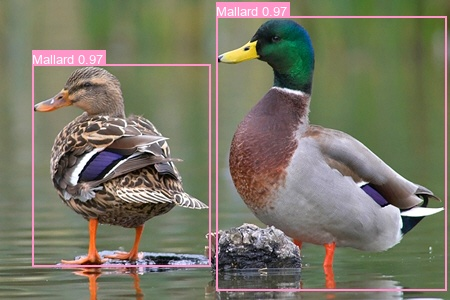

The goal of this project was to use a pretained Object Detection model and transfer learning to detect pictures of birds in an image. To this end, I chose the YOLOv8 model for its quality [documentation](https://docs.ultralytics.com/), ease of use, and proven results.

Let me walk you through the steps I undertook.

## Collecting Data

First, we will collect our bird images from [Flickr](https://www.flickr.com/). Flickr hosts many quality images from avid photographers, which make it a prime destination for bird pictures. We will need to access their API before we begin. You can request an API key from them [here](https://www.flickr.com/services/api/misc.api_keys.html).

After you applied and acquired a key, enter your Flickr API key and secret in the quotes where it says:

```python
os.environ["FLICKR_API_KEY"] = ""
os.environ["FLICKR_SECRET"] = ""
```

Now, let's install some dependencies to make image collection easier.

In [ ]:
!pip install \
flickrapi \
requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.6 MB/s eta 0:00:00


In [ ]:
from flickrapi import FlickrAPI
import os
import requests
from typing import Generator, Any

os.environ["FLICKR_API_KEY"] = ""
os.environ["FLICKR_SECRET"] = ""


birds = [
    "Mallard",
    "American Wigeon",
    "Northern Pintail",
    "Northern Shoveler",
    "Cinnamon Teal",
    "Ring-necked duck",
    "Lesser Scaup",
    "Ruddy Duck",
    "Pied-billed Grebe",
    "American White Pelican",
    "Double-crested Cormorant",
    "Black-crowned Night-Heron",
    "Green Heron",
    "Snowy Egret",
    "Great Egret",
    "Great Blue Heron",
    "Turkey Vulture",
    "Osprey",
    "Cooper’s Hawk",
    "Red-shouldered Hawk",
    "Red-tailed Hawk",
    "American Kestrel",
    "American Coot",
    "Great Horned Owl",
    "Anna’s Hummingbird",
    "Allen’s Hummingbird",
    "Belted Kingfisher",
    "Northern Flicker",
    "Downy Woodpecker",
    "Black Phoebe",
    "Western Scrub-Jay",
]

images_per_species = 100


class MissingEnvironmentVariable(Exception):
    pass


def check_env_var(var: str) -> str:
    try:
        env_var = os.environ[var]
    except KeyError:
        raise MissingEnvironmentVariable(
            f"Missing environment variable: {var}. "
            "Make sure to add your Flickr API key and Secret to .env file. "
            "See .env.example for .env format."
        )

    return env_var


def get_photos(image_tag: str) -> Generator[Any, Any, None]:
    PUBLIC_PHOTOS = 1
    PHOTOS_ONLY = 0

    api_key = check_env_var("FLICKR_API_KEY")
    secret = check_env_var("FLICKR_SECRET")

    flickr = FlickrAPI(api_key, secret)

    """
    All license values according to flickr.photos.licenses.getInfo.
    See: https://www.flickr.com/services/api/flickr.photos.licenses.getInfo.htm

    <licenses>
        <license id="0" name="All Rights Reserved" url="" />
        <license id="4" name="Attribution License" url="https://creativecommons.org/licenses/by/2.0/" />
        <license id="6" name="Attribution-NoDerivs License" url="https://creativecommons.org/licenses/by-nd/2.0/" />
        <license id="3" name="Attribution-NonCommercial-NoDerivs License" url="https://creativecommons.org/licenses/by-nc-nd/2.0/" />
        <license id="2" name="Attribution-NonCommercial License" url="https://creativecommons.org/licenses/by-nc/2.0/" />
        <license id="1" name="Attribution-NonCommercial-ShareAlike License" url="https://creativecommons.org/licenses/by-nc-sa/2.0/" />
        <license id="5" name="Attribution-ShareAlike License" url="https://creativecommons.org/licenses/by-sa/2.0/" />
        <license id="7" name="No known copyright restrictions" url="https://www.flickr.com/commons/usage/" />
        <license id="8" name="United States Government Work" url="http://www.usa.gov/copyright.shtml" />
        <license id="9" name="Public Domain Dedication (CC0)" url="https://creativecommons.org/publicdomain/zero/1.0/" />
        <license id="10" name="Public Domain Mark" url="https://creativecommons.org/publicdomain/mark/1.0/" />
    </licenses>
    """
    photos = flickr.walk(
        text=image_tag,
        privacy_filter=PUBLIC_PHOTOS,
        per_page=images_per_species,
        sort="relevance",
        license="1,2,3,4,5,6,7,8,9,10",
        content_types=PHOTOS_ONLY,
    )

    return photos


def make_dir(path: str) -> None:
    if not os.path.isdir(path):
        os.makedirs(path)


if __name__ == "__main__":
    print("Beginning flickr image scraping")

    dataset_dir = "data"
    make_dir(dataset_dir)

    for bird in birds:
        print(f"\nCreating {bird} directory...")

        bird_dir = os.path.join(os.getcwd(), dataset_dir, bird)
        make_dir(bird_dir)

        photos = get_photos(bird)

        for i, photo in enumerate(photos):
            if i >= images_per_species:
                break

            url = photo.get("url_o")

            if not url:
                farm_id = photo.get("farm")
                server = photo.get("server")
                photo_id = photo.get("id")
                secret = photo.get("secret")
                url = f"https://farm{farm_id}.staticflickr.com/{server}/{photo_id}_{secret}.jpg"

            print(f"{i + 1}) {url}")

            image_path = os.path.join(bird_dir, f"{bird}_{i}.jpg")

            with open(image_path, "wb") as file:
                file.write(requests.get(url).content)

            print(f"Saved {bird} image to {image_path}")

    print("\n\nFinished downloading")


Beginning flickr image scraping

Creating Mallard directory...


FlickrError: Error: 100: Invalid API Key (Key has invalid format)

Once that's complete, you'll see that there's a `data` directory with many subdirectories of the various bird species we've specified in the birds list. Each species subdirectory contains 100 images, which is an okay amount for training our model.

> Did you know that popular data sets tend to have thousands of images per class? ImageNet has 1000 per class while CIFAR10 has 6000 per class! That's a lot of data.

We'll now proceed to annotate this data with bounding boxes and classes. You can manually annotate by hand or automate it with [autodistill](https://github.com/autodistill/autodistill) and [GroundingDino](https://github.com/IDEA-Research/GroundingDINO).

Be warned, doing it by hand takes a long time. It took me 1 hour to annotate 200 images.

## Automated Labeling

Let's make sure that we have access to the GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click Save.

Don't try to use CPU for this! GroundingDino will run veryyyyy slow.

In [ ]:
!nvidia-smi

Install the dependencies as usual. As of 3/14/2024, `autodistill` has a [weird unpack error](https://github.com/autodistill/autodistill/issues/124) so we'll have to install a specific version of `supervision` for the code to work.

In [ ]:
!pip install -q \
autodistill \
autodistill-grounding-dino \
autodistill-yolov8 \
roboflow \
supervision==0.19.0rc2

The following code will annotate and label the bounding boxes for all our images and create a `final_dataset` directory with training and validation datasets with the images and labels assigned.

If you're running on Google Colab, beware that this will consume pretty much all your compute units, which aren't free. I would recommend using [Vast AI](https://vast.ai/) if you're on Colab or running it on a machine with poor hardware. You can follow the directions for using Vast AI's [Google Colab](https://vast.ai/docs/use-cases/google-colab) guide and rent a GPU for $5 (the minimum amount of credits you can add).

This process will take >1 hour so make sure to keep this tab open and do some chores or something.

In [ ]:
import os
import shutil
import random
import cv2
import glob
import yaml
from collections import defaultdict
from autodistill_grounding_dino import GroundingDINO
from autodistill.detection import CaptionOntology

if __name__ == '__main__':

    main_dir = "data"
    final_dir = "final_dataset"
    current_directory = os.getcwd()
    annotation_dir = os.path.join(main_dir, "annotations")
    images_dir = os.path.join(main_dir, "images")
    train_dir = os.path.join(final_dir, "train")
    valid_dir = os.path.join(final_dir, "valid")
    data_dict = defaultdict(list)
    images = {}


    os.makedirs(final_dir, exist_ok=True)
    os.makedirs(main_dir, exist_ok=True)
    os.makedirs(os.path.join(final_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(final_dir, 'labels'),exist_ok=True)
    for dir_path in [train_dir, valid_dir]:
        os.makedirs(os.path.join(dir_path, 'images'), exist_ok=True)
        os.makedirs(os.path.join(dir_path, 'labels'), exist_ok=True)


    print(len(glob.glob(os.path.join(main_dir, '*'))))
    print(glob.glob(os.path.join(main_dir, '*')))


        # loop over all sub-directories in the top-level directory
    for class_dir in glob.glob(os.path.join(main_dir, '*')):
        # get the class name from the directory name
        class_name = os.path.basename(class_dir)

        base_model = GroundingDINO(ontology=CaptionOntology({"bird": str(class_name)}))

        try:

            # label all images in a folder called `context_images`
            base_model.label(
                input_folder=class_dir,
                output_folder=os.path.join("data", str(class_name)),
                extension=".jpg"
            )

        except:
            pass


        for img_path in glob.glob(os.path.join(class_dir, '*')):
            img = cv2.imread(img_path)
            if img is not None:
                image_name = os.path.basename(img_path)
                images[image_name] = img
                data_dict[class_name].append(img_path)


      # Continue with your YAML creation, if necessary
    yaml_dict = {
        'names': list(data_dict.keys()),
        'nc': len(data_dict),
        'train': os.path.join(current_directory, final_dir, "train"),
        'val': os.path.join(current_directory, final_dir, "valid")
    }

    with open(final_dir + '/data.yaml', 'w') as file:
        yaml.dump(yaml_dict, file, default_flow_style=False)
        print("IN YAML")

    for count, folder in enumerate(os.listdir(main_dir)):
        print("Assigning class index to class name for YOLO: " + folder)
        print("Class index: " + str(count))
        source_folder_path = os.path.join(main_dir, folder, 'train')
        if os.path.isdir(source_folder_path):
            # Copy the 'images' and 'labels' subfolders to the final_dir
            for subfolder in ['images', 'labels']:
                source_subfolder_path = os.path.join(source_folder_path, subfolder)
                if os.path.exists(source_subfolder_path):
                    # Loop over each file in the subfolder and copy it to the destination
                    for file_name in os.listdir(source_subfolder_path):
                        source_file_path = os.path.join(source_subfolder_path, file_name)
                        dest_file_path = os.path.join(final_dir, subfolder, file_name)
                        if os.path.isfile(source_file_path):  # Check if it is a file, not a directory
                            # If this is an annotation file, rewrite the first value in each line
                            if subfolder == 'labels':
                                with open(source_file_path, 'r') as annot_file:
                                    lines = annot_file.readlines()
                                lines = [str(count) + line[line.find(' '):] for line in lines]
                                with open(dest_file_path, 'w') as annot_file:
                                    annot_file.writelines(lines)
                            else:
                                shutil.copy2(source_file_path, dest_file_path)  # preserves file metadata

        source_folder_path = os.path.join(main_dir, folder, 'valid')
        if os.path.isdir(source_folder_path):
            # Copy the 'images' and 'labels' subfolders to the final_dir
            for subfolder in ['images', 'labels']:
                source_subfolder_path = os.path.join(source_folder_path, subfolder)
                if os.path.exists(source_subfolder_path):
                    # Loop over each file in the subfolder and copy it to the destination
                    for file_name in os.listdir(source_subfolder_path):
                        source_file_path = os.path.join(source_subfolder_path, file_name)
                        dest_file_path = os.path.join(final_dir, subfolder, file_name)
                        if os.path.isfile(source_file_path):  # Check if it is a file, not a directory
                            # If this is an annotation file, rewrite the first value in each line
                            if subfolder == 'labels':
                                with open(source_file_path, 'r') as annot_file:
                                    lines = annot_file.readlines()
                                lines = [str(count) + line[line.find(' '):] for line in lines]
                                with open(dest_file_path, 'w') as annot_file:
                                    annot_file.writelines(lines)
                            else:
                                shutil.copy2(source_file_path, dest_file_path)  # preserves file metadata


     # Get a list of all the images and annotations
    image_files = [f for f in os.listdir(os.path.join(final_dir, "images")) if os.path.isfile(os.path.join(final_dir, "images", f))]
    print("LENGTH OF IMAGES: " + str(len(image_files)))
    annot_files = [f for f in os.listdir(os.path.join(final_dir, "labels")) if os.path.isfile(os.path.join(final_dir, "labels", f))]
    print("LENGTH OF ANNOTATIONS: " + str(len(annot_files)))

        # Assume that each image has a corresponding annotation with the same name
    # (minus the extension), shuffle the list and split into train and validation sets
    random.shuffle(image_files)
    valid_count = int(len(image_files) * 0.1)
    valid_files = image_files[:valid_count]
    train_files = image_files[valid_count:]

     # Move the files to the appropriate folders
    for filename in valid_files:
        shutil.move(os.path.join(final_dir, "images", filename), os.path.join(valid_dir, 'images', filename))
        annot_filename = os.path.splitext(filename)[0] + ".txt"
        if annot_filename in annot_files:
            shutil.move(os.path.join(final_dir, "labels", annot_filename), os.path.join(valid_dir, 'labels', annot_filename))

    for filename in train_files:
        shutil.move(os.path.join(final_dir, "images", filename), os.path.join(train_dir, 'images', filename))
        annot_filename = os.path.splitext(filename)[0] + ".txt"
        if annot_filename in annot_files:
            shutil.move(os.path.join(final_dir, "labels", annot_filename), os.path.join(train_dir, 'labels', annot_filename))
    try:
      os.removedirs(final_dir + '/images')
      os.removedirs(final_dir + '/labels')
    except:
      pass


## Training the Model

It is now time for the coup de grâce. We will train our model using a pretrained model as a starting point. This process will also take a long time.

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

# Load a pretrained YOLO model
model = YOLO("yolov8s.pt")

# Train the model using bird dataset from roboflow
model.train(
    data="final_dataset/data.yaml",
    epochs=200,
    batch=16,
    project=os.path.join(os.getcwd(), "runs"),
)

# Evaluate the model's performance on the validation set
model.val()

Let's test our model to see if it works. Get some bird pictures ready because now we'll tell our model to run some predictions on them.

In [58]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from ultralytics import YOLO
from PIL import Image
import io
import os

HOME = os.getcwd()


# Function to handle image upload and display
def on_upload(change):
    clear_output()
    uploaded_filename = next(iter(change["new"].keys()))
    uploaded_file = change["new"][uploaded_filename]["content"]

    file_name, extension = os.path.splitext(uploaded_filename)

    model = YOLO(f"{HOME}/runs/train/weights/best.pt")
    results = model.predict(uploaded_filename)

    result = results[0]
    result_img = f"{file_name}_result{extension}"
    result.save(filename=result_img)

    result_binary = open(result_img, "rb").read()

    original_img = widgets.Image(value=uploaded_file)
    object_detection_img = widgets.Image(value=result_binary)

    images = widgets.HBox([original_img, object_detection_img])
    display(images)


# Create upload button
upload_button = widgets.FileUpload(description="Upload Image", accept="image/*")

# Attach the upload handler to the button
upload_button.observe(on_upload, names="value")

# Display the upload button
display(upload_button)



image 1/1 /content/osprey.jpg: 448x640 1 Osprey, 528.4ms
Speed: 4.8ms preprocess, 528.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Hopefully, the model detected some birds in your images (if you had any). Since we're all set to go, let's zip up the `runs` directory that contains our model and data visualization stuff.

In [ ]:
!apt install zip
!zip -r runs.zip runs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
zip is already the newest version (3.0-12build2).
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Archive:  runs.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of runs.zip or
        runs.zip.zip, and cannot find runs.zip.ZIP, period.


Download the zip on your local machine. You can also go to `Files` -> Click the three dots near `runs.zip` -> `Download`.

In [ ]:
from google.colab import files
files.download('runs.zip')

You are now ready to deploy your model to detect birds for your needs!